(readapted from Toke Faurby and Chris Carvelli's)

# Lab3 Classification and Regression

The objective is to implement the core of the k-nn algorithm (most of the pre-processing and evaluation is given)

Schedule:
* Classify data using k-neighbors
* Use a confusion matrix to evaluate models

## Reminder
* [GitHub repo](https://github.com/Bhik95/data-mining-exercises)

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Take a look at the data

In [3]:
# Check that data and data path is present
basedir = "./"
file = "fifa.csv"
assert os.path.isdir(f"{basedir}data") and os.path.exists(f"{basedir}data/{file}"), 'Data not found. Make sure to have the most recent version!'

data = pd.read_csv(f'{basedir}/data/fifa.csv', sep=",")

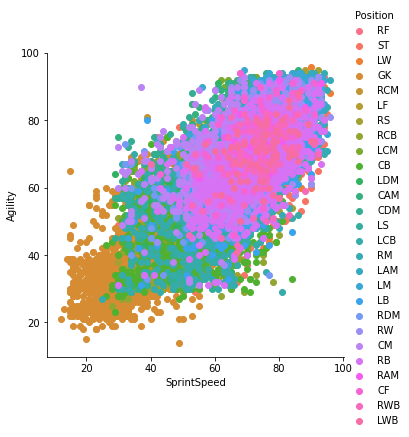

In [4]:
sns.FacetGrid(data, height=5,hue="Position").map(plt.scatter,"SprintSpeed","Agility").add_legend()

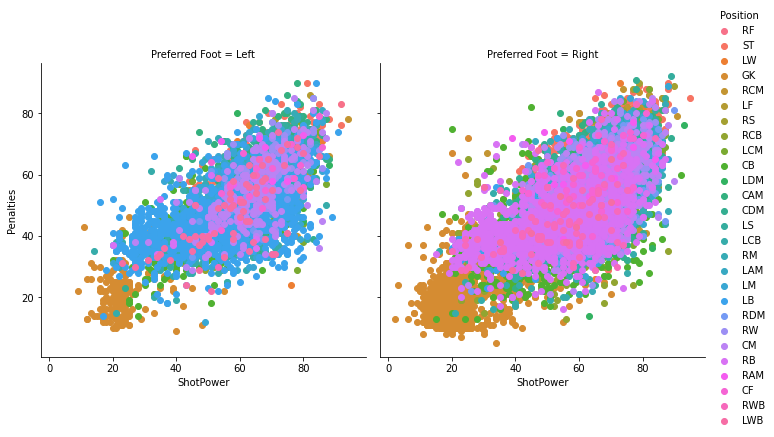

In [5]:
sns.FacetGrid(data, height=5,hue="Position", col='Preferred Foot').map(plt.scatter,"ShotPower",'Penalties').add_legend()

The scatter plots shows that the `Position` of a player could be related to some of their statistics. The dataset contains 30+ statistics and we don't know which ones will be most helpful, so we are picking an arbitrary subset to avoid the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

In [6]:
all_features = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing',
            'BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina',
            'Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure',
            'Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']

features = ["SprintSpeed","Agility","ShotPower",'Penalties']
# cleaning: remove all the lines that contain a NaN in one of the feature columns
data = data.dropna(subset=features)

# Classification problem

0. pick a value for K (number of clusters) and N (number of neighbors)
1. split the data in train and validation set
2. normalize fields
3. foreach `datapoint` in `validation set`:
  1. find the N nearest neighbors
  2. set as label of `datapoint` the label that appears most between its neighbors

In [7]:
# 0: define K
K = 5

# Normalization (Standardization):
data[features] = data[features].sub(data[features].mean(0)).divide(data[features].std(0))

c:\users\frass\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Choose the right K can be tricky. As usual, [stand on the shoulder of giants](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Parameter_selection)

# Step-by-step implementation

In [8]:
# 3.1: let's start with calculating the Euclidean distance from a single datapoint to all the other

# parameters:
# 1) the single data entry to classify, x
# 2) the name of the class columns, class_col
# 3) the training set, train_set
knn_classification = lambda x, class_col, train_set: (
                                train_set[features].sub(x[features]) # .sub means subraction: train_set[features] - x[features]
                               .pow(2).sum(axis=1).pow(0.5)
                            )

# the first row of the result should be 0, since we are calculating the distance between a point and itself
# check pandas API for iloc[] if necessary
knn_classification(data.iloc[0], 'Position', data)

0        0.000000
1        0.965343
2        0.647548
3        4.779226
4        1.145604
           ...   
18202    4.291234
18203    5.817492
18204    4.007839
18205    3.760857
18206    4.848800
Length: 18159, dtype: float64

In [9]:
# 3.2: to implement k-nn, we need the K closest neighbors. We'll get them with a pandas function,
# for convenience and performance

knn_classification = lambda x, class_col, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(axis=1).pow(0.5)
                               .nsmallest(K)
                               )

knn_classification(data.iloc[0], 'Position', data)

0      0.000000
138    0.230010
173    0.230992
893    0.350109
750    0.351535
dtype: float64

In [10]:
# 3.3: from here, we need the labels associated to this rows. The result is still referencing to our original dataset
# (the left column is the index on the original dataset), so we can use iloc[] as before for this

# let's also move everything we did up until now in a different function
nearest_neighbors = lambda x, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(axis=1).pow(0.5)
                               .nsmallest(K)
                               ).index # retrieve the indices (INDICES != POSITIONS!!!)


knn_classification = lambda x, class_col, train_set: (
    # IMPORTANT: .loc[] instead of .iloc[] (see next cell)
    train_set.loc[nearest_neighbors(x, train_set)]
)


knn_classification(data.iloc[0], 'Position', data)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
138,138,183898,A. Di María,30,https://cdn.sofifa.org/players/4/19/183898.png,Argentina,https://cdn.sofifa.org/flags/52.png,84,84,Paris Saint-Germain,...,82.0,35.0,59.0,56.0,10.0,7.0,11.0,12.0,11.0,€54.6M
173,173,208418,Y. Carrasco,24,https://cdn.sofifa.org/players/4/19/208418.png,Belgium,https://cdn.sofifa.org/flags/7.png,83,86,Dalian YiFang FC,...,75.0,58.0,39.0,26.0,9.0,11.0,9.0,10.0,10.0,€73.4M
893,893,184575,R. Alessandrini,29,https://cdn.sofifa.org/players/4/19/184575.png,France,https://cdn.sofifa.org/flags/18.png,78,78,LA Galaxy,...,77.0,53.0,55.0,34.0,11.0,12.0,9.0,16.0,9.0,€15M
750,750,226377,G. Martínez,25,https://cdn.sofifa.org/players/4/19/226377.png,Argentina,https://cdn.sofifa.org/flags/52.png,78,82,River Plate,...,77.0,41.0,28.0,30.0,6.0,9.0,13.0,12.0,15.0,€19.9M


In [11]:
# 3.4: now that we have the neigbors, lets get their labels and select the one that appear more times
nearest_neighbors = lambda x, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(1).pow(0.5)
                               .nsmallest(K)
                               ).index


knn_classification = lambda x, class_col, train_set: (
    # IMPORTANT: .loc[] instead of .iloc[] (see next cell)
    train_set.loc[nearest_neighbors(x, train_set)]
        [class_col]
        .mode() # get the mode (the most frequent value)
)

# this time we are using a different datapoint, it will show us a problem
knn_classification(data.iloc[6], 'Position', data)

0    RCM
dtype: object

# loc[] vs iloc[]

`iloc[]` and `loc[]` seem similar but actually they are QUITE different:
- `loc[i]` returns the row with index `i`
- `iloc[i]` returns the row in the `i`-th position

When creating a dataset (unless directly specified), the index of a row is just in position, so both functions will return the same row. That doesn't hold true after manipulating the DataFrame (eg, cleaning, sorting, etc).

The correct way to reference a dataset using the entries of a DataFrame `a` from the entries af another DataFrame `b` is:
```
a.loc[b.index]
```

In [12]:
# 3.5: some of the modes that we will calculate will return more than one value. This won't work,
#      so we need to pick one of them. The best solution would be to assign a weight to each neighbor
#      based on its distance (see lecture's slides), sum the weights grouped by label and pick the label
#      with the highest score.

nearest_neighbors = lambda x, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(1).pow(0.5)
                               .nsmallest(K)
                               ).index


knn_classification = lambda x, class_col, train_set: (
    # IMPORTANT: .loc[] instead of .iloc[] (see next cell)
    train_set.loc[nearest_neighbors(x, train_set)]
        [class_col]
        .mode()[0]
)


knn_classification(data.iloc[6], 'Position', data)

'RCM'

In [13]:
def classify(dataset, class_col, random_state=None, frac=0.995):
    # 1: random split. It's always a good idea (maybe the dataset is sorted, and so on).
    # random_state that you to always get the same split (useful for testing). Check docs
    train_set = data.sample(frac=frac, random_state=random_state)
    valid_set = data.drop(train_set.index)

    classified_set = valid_set
    classified_set[f'Calculated {class_col}'] = valid_set.apply(
        lambda x: knn_classification(x, class_col, train_set),
        axis=1
    )
    return classified_set

classified_position = classify(data, 'Position')[['Position', 'Calculated Position']]
classified_position

,Position,Calculated Position
11,LCM,RM
61,CAM,ST
155,RW,LM
221,LM,CAM
262,CM,LB
...,...,...
16141,CB,CB
16461,LM,CB
16625,RM,CAM
16856,LB,LB


# Binary classification with positive class
In many cases, it's important to determine if a datapoint belongs or not to a certain class or not and the distribution is skewed (poisonus/not poisonus, cancer/not cancer, ...)

In [14]:
# If you get a warning, please ignore it, everything works fine and I could not figure out what's the problem :/

K = 3

data['Goalkeeper'] = data['Position'] == 'GK'

classified_goalkeeper = classify(data, 'Goalkeeper', frac=0.99)[['Goalkeeper', 'Calculated Goalkeeper']]

<ipython-input-14-0ab4a4689756>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Goalkeeper'] = data['Position'] == 'GK'


In [15]:
classified_goalkeeper

,Goalkeeper,Calculated Goalkeeper
94,False,False
159,False,False
163,False,False
214,True,True
268,False,False
...,...,...
18000,False,False
18024,False,False
18038,False,False
18160,True,True


# Classification evaluation

1. generate confusion matrix
2. evaluate the classification

In [16]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig


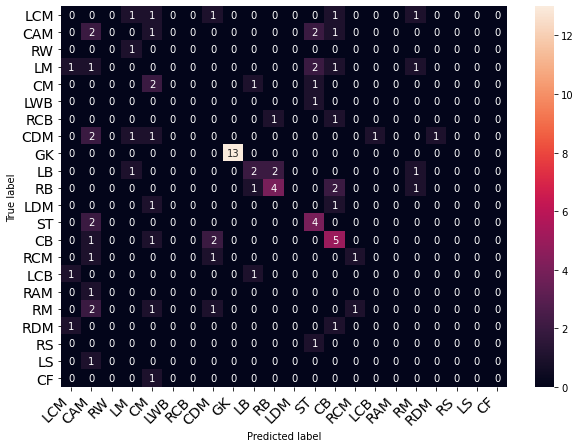

Precision: 0.3626373626373626


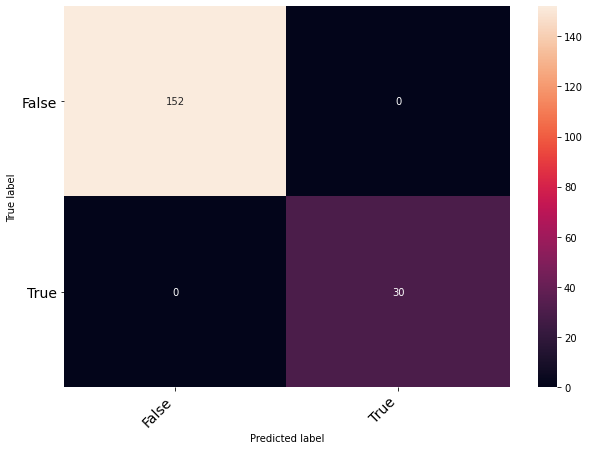

[152   0   0  30]
Accuracy: 1.0
Error rate: 0.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0


In [17]:
def print_results(data, class_col, binary=False):
    labels = data[class_col].unique()
    #TODO: Calculate the confusion matrix (look at sklearn.metrics.confusion_matrix)
    cm = confusion_matrix(data[class_col], data[f'Calculated {class_col}'], labels=labels)

    print_confusion_matrix(
        cm,
        labels
    )
    plt.show()  # wait for the render (otherwise it will print the graphs async, after the strings)
    
    if binary:
        tn, fp, fn, tp = cm.ravel()

        #TODO: Calculate the following metrics starting from tn, fp, fn and tp:
        accuracy = (tp + tn) / (tn + fp + fn + tp)
        err_rate = (fp + fn) / (tn + fp + fn + tp)
        sensitiv = (tp) / (fp + tp)
        specific = (tn) / (tn + fn)
        precision = (tp) / (tp + tn)

        print(cm.ravel())
        print(f'Accuracy: {accuracy}')
        print(f'Error rate: {err_rate}')
        print(f'Sensitivity: {sensitiv}')
        print(f'Specificity: {specific}')
        print(f'Precision: {specific}')
    else:
        diag = [cm[i][i] for i in range(len(cm))]        
        rows = [sum(cm[i]) for i in range(len(cm))]
        
        right_pred = sum(diag)
        wrong_pred = sum(rows)
        
        print(f'Precision: {right_pred / wrong_pred}')
    
        
    
    
print_results(classified_position, 'Position')
print_results(classified_goalkeeper, 'Goalkeeper', binary=True)

The accuracy seems high for the `Goalkeeper` class, but because the percentage of goalkeepers is low. In those cases, Sensitivity is a much better metric. Here will probably be very low because the metric are chosen arbitrarly. You can check the link above to see how to pick appropriate dimensions.

Additionally, for skewed distributions:
> A drawback of the basic "majority voting" classification occurs when the class distribution is skewed. That is, examples of a more frequent class tend to dominate the prediction of the new example, because they tend to be common among the k nearest neighbors due to their large number[[4]](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#cite_note-Coomans_Massart1982-4). One way to overcome this problem is to weight the classification, taking into account the distance from the test point to each of its k nearest neighbors. The class (or value, in regression problems) of each of the k nearest points is multiplied by a weight proportional to the inverse of the distance from that point to the test point